<a href="https://colab.research.google.com/github/parth2601/MLP-vs-SNN/blob/main/Copy_of_MLP_vs_SNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparative Analysis of MLP and SNN on MNIST Dataset

## Introduction

This notebook performs a comparative analysis of the MNIST dataset using both a Multi-Layer Perceptron (MLP) and a Spiking Neural Network (SNN). We will:

- Load and preprocess the MNIST dataset.
- Define and train both MLP and SNN models.
- Evaluate and compare their performance.
- Visualize the results and save all plots.

In [ ]:
pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 3.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
import time
import numpy as np

import snntorch as snn
from snntorch import spikegen

torch.manual_seed(0)

## Dataset Loading and Preprocessing

We will load the MNIST dataset and apply normalization to enhance the training process.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform)

batch_size = 64

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

#only for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.0MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Using device: cuda


## MLP Model Definition

We will define a simple MLP model with one hidden layer.

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

mlp_model = MLP().to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(mlp_model.parameters(), lr=learning_rate)

## Training and Testing Functions for MLP

In [ ]:
def train_mlp(model, device, train_loader, optimizer, criterion):
    model.train()
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_acc = 100 * correct / total
    return train_acc

def test_mlp(model, device, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    test_acc = 100 * correct / total
    return test_acc

## Training the MLP Model

In [ ]:
num_epochs = 10
mlp_train_acc_list = []
mlp_test_acc_list = []

print("Training MLP Model...")
start_time = time.time()

for epoch in range(1, num_epochs+1):
    train_acc = train_mlp(mlp_model, device, train_loader, optimizer, criterion)
    test_acc = test_mlp(mlp_model, device, test_loader, criterion)

    mlp_train_acc_list.append(train_acc)
    mlp_test_acc_list.append(test_acc)

    print(f'Epoch [{epoch}/{num_epochs}], Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')

mlp_training_time = time.time() - start_time
print(f'MLP Training Time: {mlp_training_time:.2f} seconds\n')

Training MLP Model...
Epoch [1/10], Train Accuracy: 93.06%, Test Accuracy: 96.06%
Epoch [2/10], Train Accuracy: 97.13%, Test Accuracy: 97.16%
Epoch [3/10], Train Accuracy: 98.05%, Test Accuracy: 97.42%
Epoch [4/10], Train Accuracy: 98.53%, Test Accuracy: 97.71%
Epoch [5/10], Train Accuracy: 98.78%, Test Accuracy: 97.60%
Epoch [6/10], Train Accuracy: 98.98%, Test Accuracy: 97.74%
Epoch [7/10], Train Accuracy: 99.18%, Test Accuracy: 97.92%
Epoch [8/10], Train Accuracy: 99.39%, Test Accuracy: 97.78%
Epoch [9/10], Train Accuracy: 99.36%, Test Accuracy: 97.77%
Epoch [10/10], Train Accuracy: 99.43%, Test Accuracy: 97.84%
MLP Training Time: 162.62 seconds



## SNN Model Definition using snntorch

We will define the SNN model using `snntorch` with leaky integrate-and-fire neurons.

In [ ]:
beta = 0.9  #Decay rate for the leaky neuron

class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(256, 10)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        num_steps = 100
        x = x.view(x.size(0), -1)

        spike_input = spikegen.rate(x, num_steps=num_steps)

        spk2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(spike_input[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)

        out = torch.stack(spk2_rec, dim=0).sum(dim=0)
        return out

snn_model = SNN().to(device)

criterion_snn = nn.CrossEntropyLoss()
optimizer_snn = optim.Adam(snn_model.parameters(), lr=learning_rate)

## Training and Testing Functions for SNN

In [ ]:
def train_snn(model, device, train_loader, optimizer, criterion):
    model.train()
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_acc = 100 * correct / total
    return train_acc

def test_snn(model, device, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    test_acc = 100 * correct / total
    return test_acc

## Training the SNN Model

In [ ]:
snn_train_acc_list = []
snn_test_acc_list = []

print("Training SNN Model...")
start_time_snn = time.time()

for epoch in range(1, num_epochs+1):
    train_acc = train_snn(snn_model, device, train_loader, optimizer_snn, criterion_snn)
    test_acc = test_snn(snn_model, device, test_loader, criterion_snn)

    snn_train_acc_list.append(train_acc)
    snn_test_acc_list.append(test_acc)

    print(f'Epoch [{epoch}/{num_epochs}], SNN Train Accuracy: {train_acc:.2f}%, SNN Test Accuracy: {test_acc:.2f}%')

snn_training_time = time.time() - start_time_snn
print(f'SNN Training Time: {snn_training_time:.2f} seconds\n')

Training SNN Model...
Epoch [1/10], SNN Train Accuracy: 88.32%, SNN Test Accuracy: 94.47%
Epoch [2/10], SNN Train Accuracy: 95.61%, SNN Test Accuracy: 96.35%
Epoch [3/10], SNN Train Accuracy: 96.52%, SNN Test Accuracy: 95.35%
Epoch [4/10], SNN Train Accuracy: 96.87%, SNN Test Accuracy: 96.13%
Epoch [5/10], SNN Train Accuracy: 97.22%, SNN Test Accuracy: 96.55%
Epoch [6/10], SNN Train Accuracy: 97.31%, SNN Test Accuracy: 96.46%
Epoch [7/10], SNN Train Accuracy: 97.71%, SNN Test Accuracy: 96.65%
Epoch [8/10], SNN Train Accuracy: 97.88%, SNN Test Accuracy: 96.39%
Epoch [9/10], SNN Train Accuracy: 97.80%, SNN Test Accuracy: 96.44%
Epoch [10/10], SNN Train Accuracy: 98.05%, SNN Test Accuracy: 96.51%
SNN Training Time: 2094.62 seconds



## Comparison and Evaluation


In [ ]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for data, labels in loader:
            data = data.to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            all_preds = torch.cat((all_preds, preds.cpu()), dim=0)
            all_labels = torch.cat((all_labels, labels), dim=0)
    return all_preds, all_labels

### Obtain Predictions for Both Models

In [ ]:
mlp_preds, mlp_true = get_all_preds(mlp_model, test_loader)

snn_preds, snn_true = get_all_preds(snn_model, test_loader)

## Confusion Matrices

### Confusion Matrix for MLP

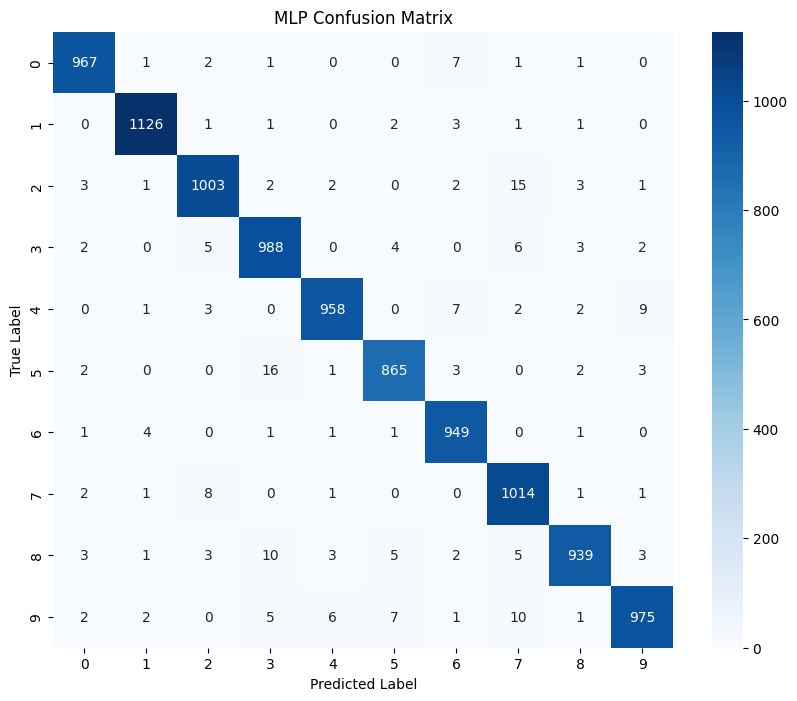

In [ ]:
mlp_cm = confusion_matrix(mlp_true, mlp_preds)
plt.figure(figsize=(10,8))
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues')
plt.title('MLP Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('mlp_confusion_matrix.png')
plt.show()

### Confusion Matrix for SNN

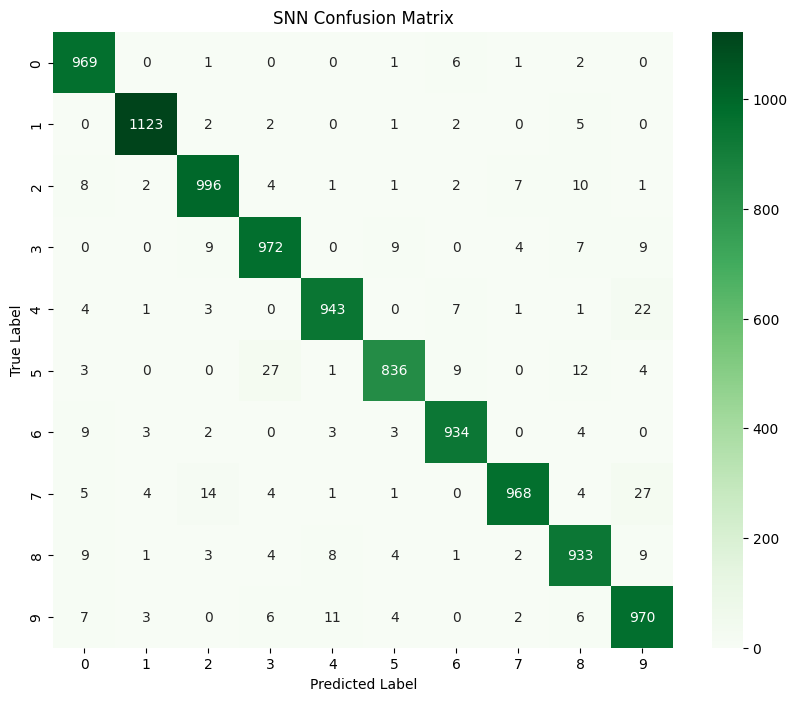

In [ ]:
snn_cm = confusion_matrix(snn_true, snn_preds)
plt.figure(figsize=(10,8))
sns.heatmap(snn_cm, annot=True, fmt='d', cmap='Greens')
plt.title('SNN Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('snn_confusion_matrix.png')
plt.show()

## Visualization of Misclassified Samples

### Function to Plot Misclassified Samples

In [ ]:
def plot_misclassified_samples(dataset, misclassified_idx, preds, true_labels, title, filename):
    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(misclassified_idx[:25]):
        idx = idx.item()
        image, label = dataset[idx]
        plt.subplot(5,5,i+1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f'True: {true_labels[idx]}, Pred: {preds[idx]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

### Plot Misclassified Samples for MLP

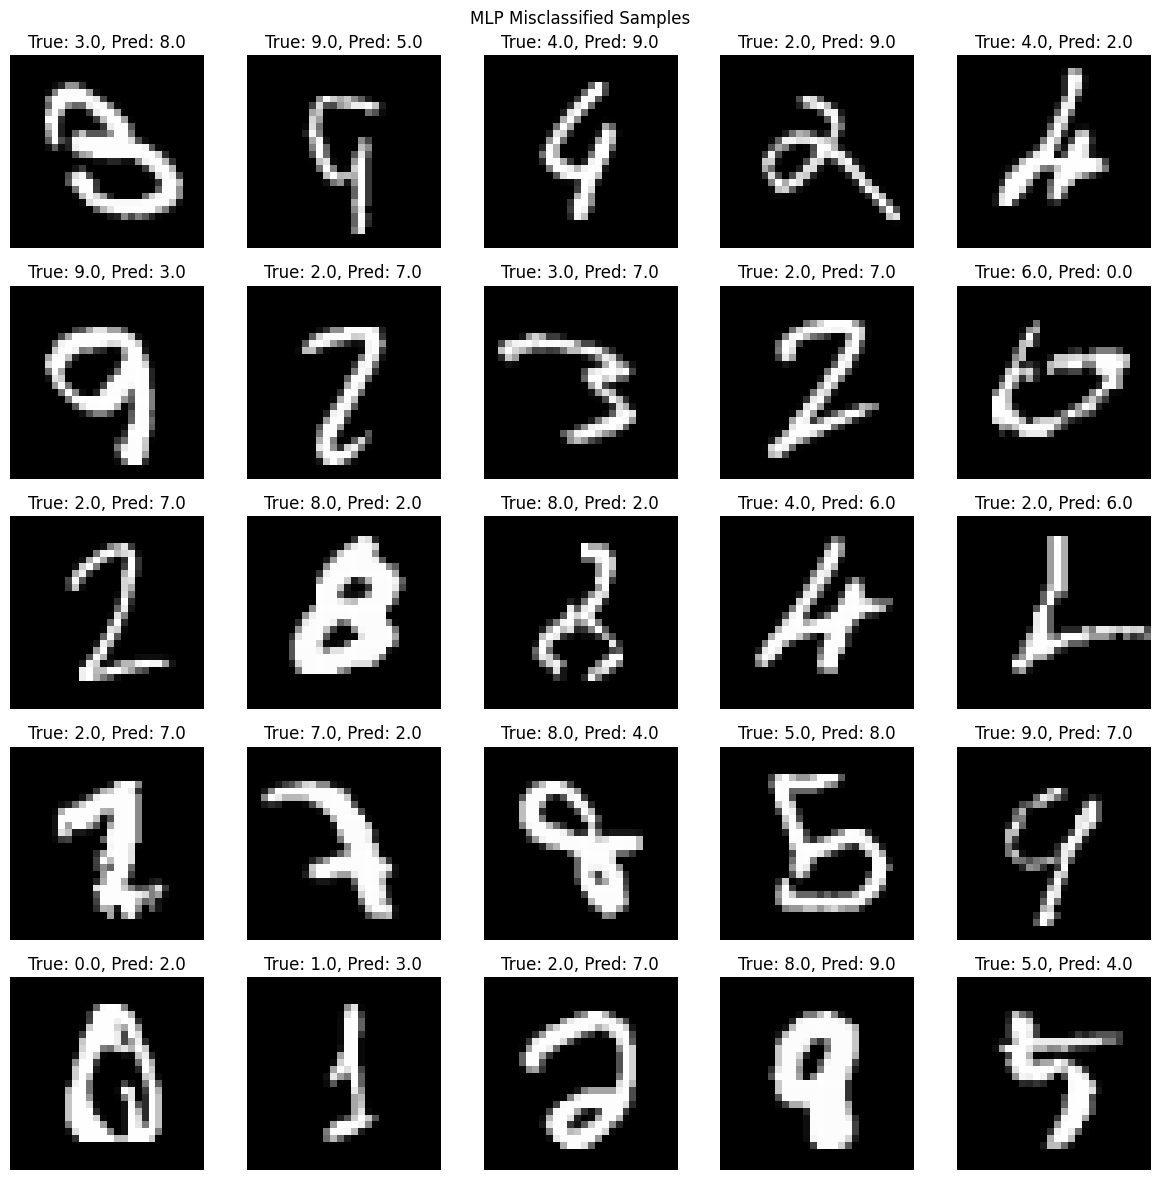

In [ ]:
mlp_misclassified_idx = (mlp_preds != mlp_true).nonzero()
plot_misclassified_samples(test_dataset, mlp_misclassified_idx, mlp_preds, mlp_true, 'MLP Misclassified Samples', 'mlp_misclassified_samples.png')

### Plot Misclassified Samples for SNN

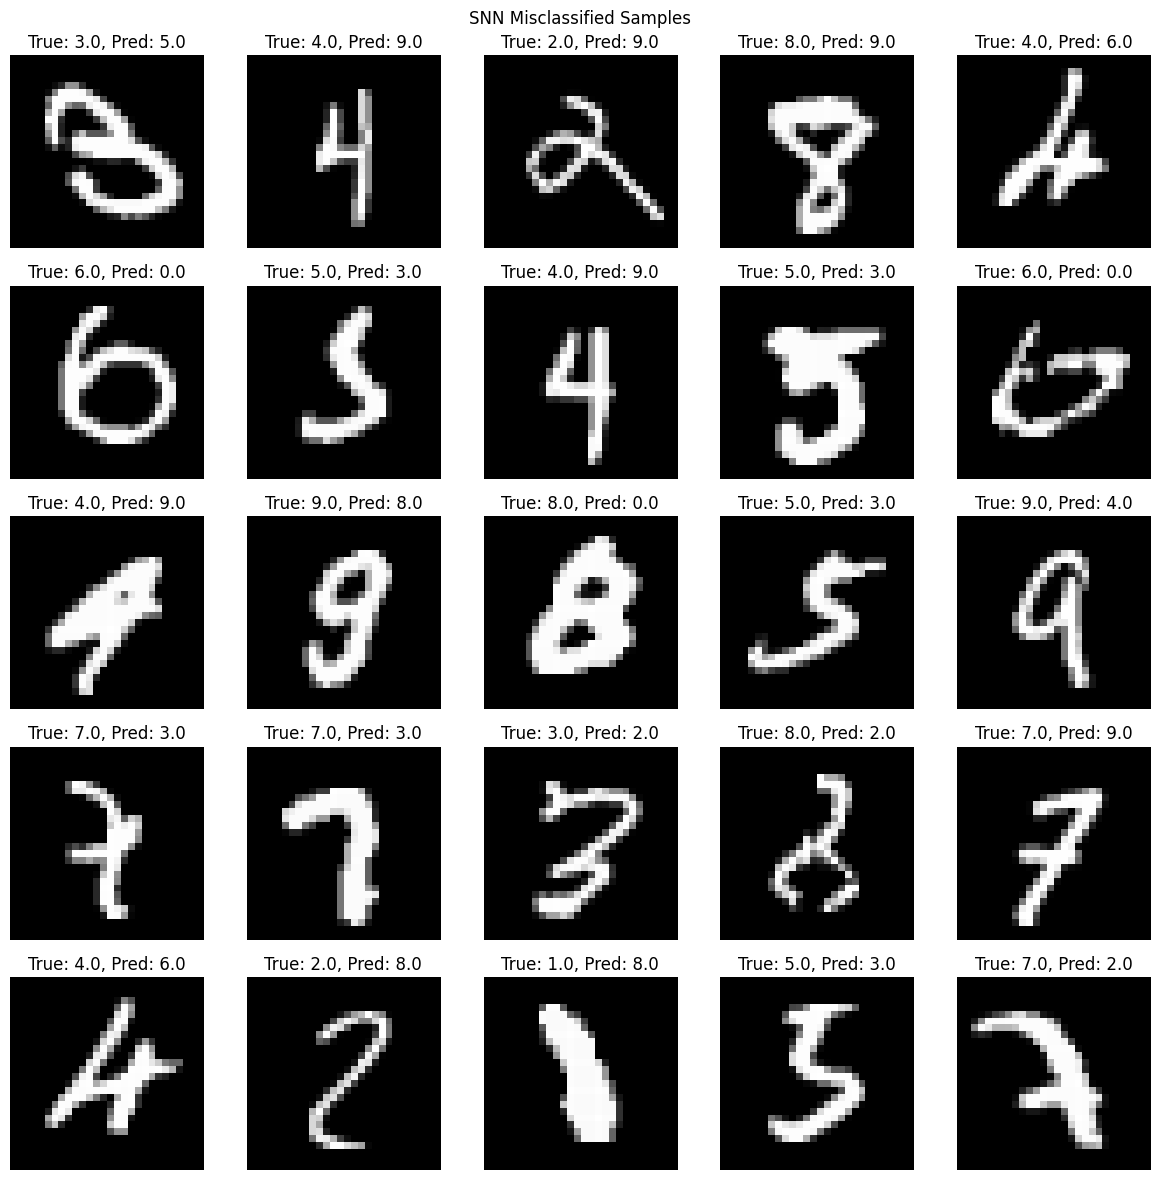

In [ ]:
snn_misclassified_idx = (snn_preds != snn_true).nonzero()
plot_misclassified_samples(test_dataset, snn_misclassified_idx, snn_preds, snn_true, 'SNN Misclassified Samples', 'snn_misclassified_samples.png')

## Plotting and Visualization

### Accuracy Over Epochs

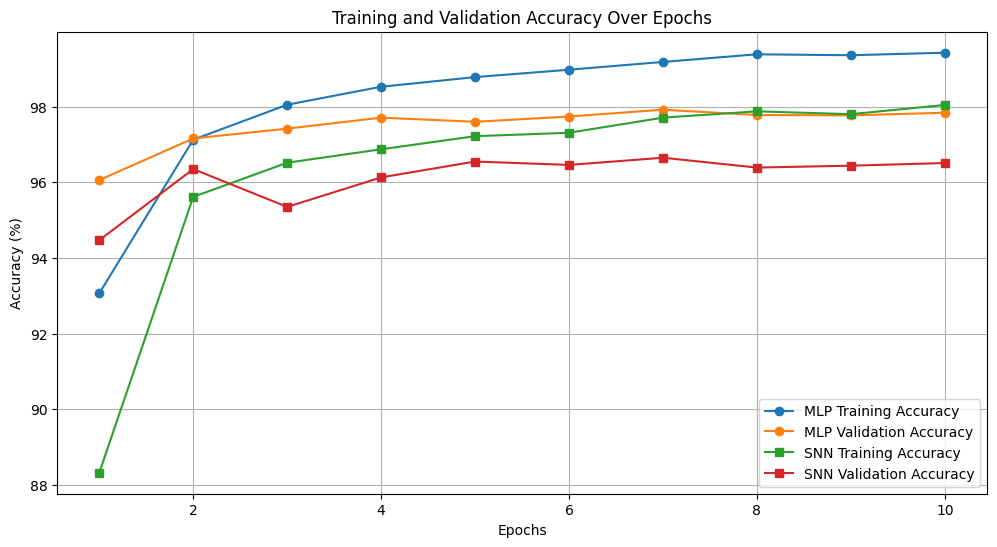

In [ ]:
epochs_range = range(1, num_epochs+1)

plt.figure(figsize=(12,6))
plt.plot(epochs_range, mlp_train_acc_list, label='MLP Training Accuracy', marker='o')
plt.plot(epochs_range, mlp_test_acc_list, label='MLP Validation Accuracy', marker='o')
plt.plot(epochs_range, snn_train_acc_list, label='SNN Training Accuracy', marker='s')
plt.plot(epochs_range, snn_test_acc_list, label='SNN Validation Accuracy', marker='s')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_over_epochs.png')
plt.show()

### Comparative Bar Chart of Final Accuracy

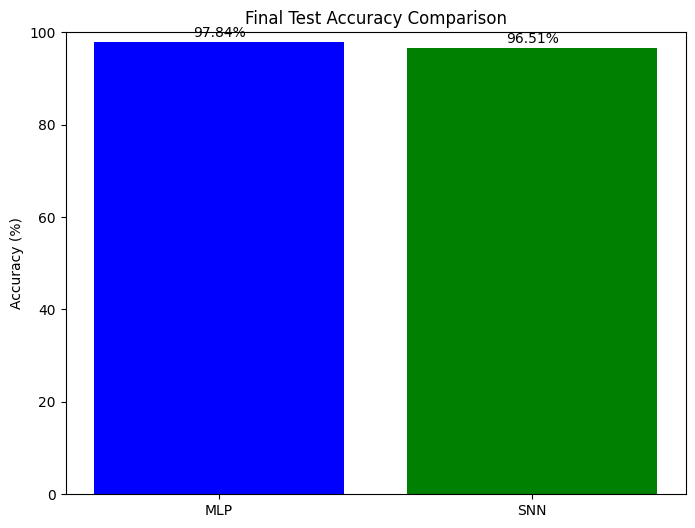

In [ ]:
final_accuracies = {
    'MLP': mlp_test_acc_list[-1],
    'SNN': snn_test_acc_list[-1]
}

plt.figure(figsize=(8,6))
bars = plt.bar(final_accuracies.keys(), final_accuracies.values(), color=['blue', 'green'])
plt.title('Final Test Accuracy Comparison')
plt.ylabel('Accuracy (%)')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom')

plt.ylim(0, 100)
plt.savefig('final_accuracy_comparison.png')
plt.show()

## Final Accuracy Metrics and Training Times

In [ ]:
print(f'MLP Final Test Accuracy: {mlp_test_acc_list[-1]:.2f}%')
print(f'SNN Final Test Accuracy: {snn_test_acc_list[-1]:.2f}%')
print(f'MLP Training Time: {mlp_training_time:.2f} seconds')
print(f'SNN Training Time: {snn_training_time:.2f} seconds')

MLP Final Test Accuracy: 97.84%
SNN Final Test Accuracy: 96.51%
MLP Training Time: 162.62 seconds
SNN Training Time: 2094.62 seconds


## Conclusion

In this notebook, we have:

- Trained and evaluated an MLP and an SNN on the MNIST dataset.
- Compared their performance in terms of accuracy and training time.
- Visualized the confusion matrices and misclassified samples.
- Saved all the generated charts and graphs to the local directory.

---

**Important Notes:**

- **Saving Plots:** The `plt.savefig()` function is used to save the plots to your local directory. Ensure that you have write permissions to the directory where you're running the notebook.

- **Installing snntorch:** If you haven't installed `snntorch`, you can install it using:

  ```bash
  pip install snntorch
  ```

- **Computational Resources:** Training the SNN model may require more computational time and resources due to the simulation over multiple time steps. Using a GPU is highly recommended.

- **Adjusting Parameters:** Feel free to adjust the hyperparameters like learning rate, batch size, number of epochs, and the decay rate `beta` in the SNN model to experiment and potentially improve performance.

- **Visualizing Spiking Activity:** To visualize neuron spiking activity in the SNN, you can modify the `forward` method to record spikes and plot them. This is an advanced topic and can be explored further if interested.

